In [3]:
import numpy as np
from glob import glob
import os
import des_utils
import des_io
import trigColors
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackEnd.figure_format='retina'
import matplotlib.transforms as transforms

In this document, I plot the 

1 698
0.1 0.001 0.00143266475645 0.00719424460432
249 6570
0.1 0.01 0.037899543379 0.0551128818061
1500 7078
0.1 0.1 0.211924272393 0.309229864785
2 667
0.2 0.001 0.00299850074963 0.0062893081761
462 6521
0.2 0.01 0.0708480294433 0.109395109395
2624 7251
0.2 0.1 0.361881119846 0.226404800873
6 535
0.3 0.001 0.011214953271 0.0
535 5164
0.3 0.01 0.103601859024 0.130649137223
3084 5840
0.3 0.1 0.528082191781 0.41127348643
0 698
0.1 0.001 0.0 0.0
80 6570
0.1 0.01 0.0121765601218 0.0192563081009
457 7078
0.1 0.1 0.0645662616558 0.142857142857
0 667
0.2 0.001 0.0 0.0
180 6521
0.2 0.01 0.0276031283545 0.0495495495495
1969 7251
0.2 0.1 0.271548751896 0.196944899073
1 535
0.3 0.001 0.0018691588785 0.0
179 5164
0.3 0.01 0.0346630518978 0.0443714050945
1683 5840
0.3 0.1 0.288184931507 0.302713987474
0 698
0.1 0.001 0.0 0.0
20 6570
0.1 0.01 0.00304414003044 0.00730411686587
139 7078
0.1 0.1 0.0196383159084 0.0399764844209
0 667
0.2 0.001 0.0 0.0
45 6521
0.2 0.01 0.00690078208864 0.0173745173745
11

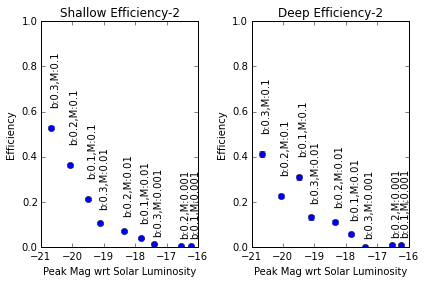

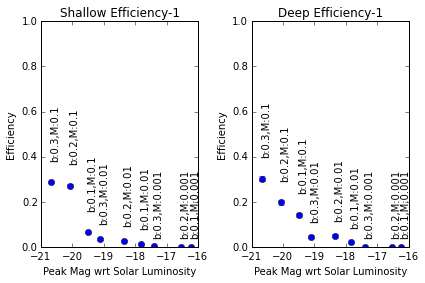

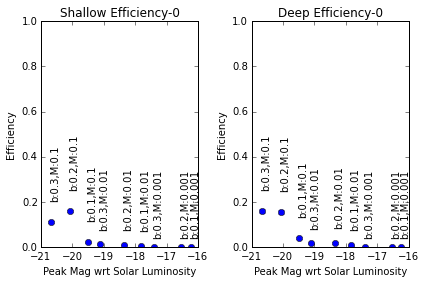

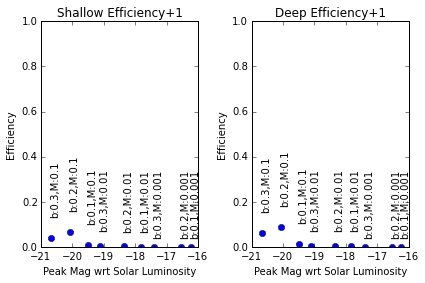

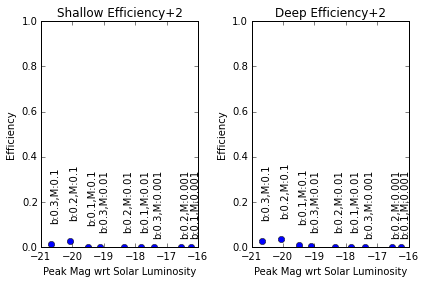

In [4]:
offsets = ['-2','-1','-0','+1','+2']
for offset in offsets:
    simpath = '../KNSimDataRateLims081715_z0.2/ZDNTEST_MAGOFF'+offset+'/*DAT'
    filetypes = ['sim']#['sim','data']
    paths = [simpath,"../DESY1_numepoch1_iz_real_text/*.dat"]
    fieldtypes = ['shallow','deep']
    dict1 = dict()  
    for n,fieldtype in enumerate(fieldtypes):
        dict1['sim_'+fieldtype] = trigColors.trigColors(simpath,'sim',fieldtype)
        dict1['sim_'+fieldtype]['detections'] = des_utils.get_detection_flags_list(dict1['sim_'+fieldtype]['cnites'],
                                                                                         dict1['sim_'+fieldtype]['zbandinfo'],
                                                                                         dict1['sim_'+fieldtype]['ibandinfo'],
                                                                                         3,10,1)
    L_bol = np.matrix([[1.2e40,1.6e40,3.5e40],[5.2e40,8.5e40,1.7e41],[2.4e41,4.1e41,7.2e41]]) # Each sub array is constant M going up in M from left to right.
    bolMag = -2.5*np.log10(L_bol/float(3.846e33))
    # within each sub array, go up in beta from left to right.
    beta = [0.1,0.2,0.3]
    M_sol = [0.001,0.01,0.1]
    dumpfile = "../KNSimDataRateLims081715_z0.2/ZDNTEST_MAGOFF" + offset +"/ZDNTEST_MAGOFF" + offset + ".DUMP"
    dumpdata = np.genfromtxt(dumpfile,skip_header=2)
    dumpbeta = np.around(np.array(dumpdata[:,30]),5)
    dumpM = np.around(np.array(dumpdata[:,31]),5)
    dumpSN = dumpdata[:,1]
    dumpSN = np.array([int(dumpSN[i]) for i,eye in enumerate(dumpSN)])
    dumpMu = dumpdata[:,12]
    dumpPeakMag = dumpdata[:,17]
    dumpFields = np.genfromtxt(dumpfile,skip_header=2,usecols=(8),dtype=None)
    modelDict = dict()
    simSNIDlist = [int(eye['SNID']) for i,eye in enumerate(dict1['sim_shallow']['headers'])]
    fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True)
    for bnum,b in enumerate(beta):
        for Mnum,M in enumerate(M_sol):
            key = 'b'+str(b)+'_'+'m'+str(M)
            Msel = dumpM == M
            bsel = dumpbeta == b 
            deep = (dumpFields == 'C3') | (dumpFields == 'X3')
            shal = ~deep
            shalsel = Msel & bsel & shal
            deepsel = Msel & bsel & deep
            #modelDict[key] = dict()
            #modelDict[key]['SN'] = dumpSN[sel]
            shalSN = dumpSN[shalsel]
            deepSN = dumpSN[deepsel]
            totalshal = len(shalSN)
            totaldeep = len(deepSN)
            #modelDict[key]['Mu'] = dumpMu[sel]
            #modelDict[key]['PeakMag'] = dumpPeakMag[sel]
            #print b,M,np.mean(modelDict[key]['PeakMag']-modelDict[key]['Mu'])
            shalSNIDsel = np.in1d(simSNIDlist,shalSN)
            deepSNIDsel = np.in1d(simSNIDlist,deepSN)
            totalshalcut = np.sum(shalSNIDsel &dict1['sim_shallow']['trigs'] & dict1['sim_shallow']['detections'] & dict1['sim_shallow']['multitrig'])
            totaldeepcut = np.sum(deepSNIDsel &dict1['sim_deep']['trigs'] & dict1['sim_deep']['detections'] & dict1['sim_deep']['multitrig'])
            print totalshalcut, totalshal
            shalEff = float(totalshalcut)/float(totalshal)
            deepEff = float(totaldeepcut)/float(totaldeep)
            shalErr = np.sqrt(float(totalshalcut)*(1-shalEff))/float(totalshal)
            deepErr = np.sqrt(float(totaldeepcut)*(1-deepEff))/float(totaldeep)
            print b,M,shalEff,deepEff
            ax = axs[0]
            ax.errorbar(bolMag[Mnum,bnum], shalEff, yerr=shalErr,color='b',fmt='--o')
            ax.set_title('Shallow Efficiency'+offset)
            ax.set_xlabel('Peak Mag wrt Solar Luminosity')
            ax.set_ylabel('Efficiency')
            ax.text(bolMag[Mnum,bnum], (shalEff+.3),'b:'+str(b)+',M:'+str(M),rotation='vertical')
            ax.set_ylim([0,1])
            ax = axs[1]
            ax.errorbar(bolMag[Mnum,bnum], deepEff, yerr=deepErr,color='b',fmt='--o')
            ax.set_title('Deep Efficiency'+offset)
            ax.set_xlabel('Peak Mag wrt Solar Luminosity')
            ax.set_ylabel('Efficiency')
            ax.text(bolMag[Mnum,bnum], (deepEff+.3),'b:'+str(b)+',M:'+str(M),rotation='vertical')
            ax.set_ylim([0,1])
    plt.tight_layout()
 

[[-16.23542992 -16.54777676 -17.39764691]
 [-17.82748516 -18.36102411 -19.1135991 ]
 [-19.4880049  -20.06943644 -20.68080804]]
0 121
0.1 0.001 0.0 0.0
70 1315
0.1 0.01 0.0532319391635 0.06875
393 1382
0.1 0.1 0.284370477569 0.376770538244
2 139
0.2 0.001 0.0143884892086 0.0
138 1330
0.2 0.01 0.103759398496 0.151898734177
564 1504
0.2 0.1 0.375 0.243169398907
0 83
0.3 0.001 0.0 0.0
134 1023
0.3 0.01 0.130987292278 0.18410041841
702 1167
0.3 0.1 0.601542416452 0.456273764259


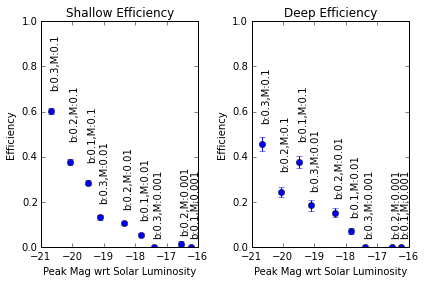

In [113]:
L_bol = np.matrix([[1.2e40,1.6e40,3.5e40],[5.2e40,8.5e40,1.7e41],[2.4e41,4.1e41,7.2e41]]) # Each sub array is constant M going up in M from left to right.
bolMag = -2.5*np.log10(L_bol/float(3.846e33))
print bolMag
# within each sub array, go up in beta from left to right.
beta = [0.1,0.2,0.3]
M_sol = [0.001,0.01,0.1]
dumpfile = "../KNSimDataRateLims081315/ZDNTEST_MAGOFF" + offset +"/ZDNTEST_MAGOFF" + offset + ".DUMP"
dumpdata = np.genfromtxt(dumpfile,skip_header=2)
dumpbeta = np.around(np.array(dumpdata[:,30]),5)
dumpM = np.around(np.array(dumpdata[:,31]),5)
dumpSN = dumpdata[:,1]
dumpSN = np.array([int(dumpSN[i]) for i,eye in enumerate(dumpSN)])
dumpMu = dumpdata[:,12]
dumpPeakMag = dumpdata[:,17]
dumpFields = np.genfromtxt(dumpfile,skip_header=2,usecols=(8),dtype=None)
modelDict = dict()
simSNIDlist = [int(eye['SNID']) for i,eye in enumerate(dict1['sim_shallow']['headers'])]
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True)
for bnum,b in enumerate(beta):
    for Mnum,M in enumerate(M_sol):
        key = 'b'+str(b)+'_'+'m'+str(M)
        Msel = dumpM == M
        bsel = dumpbeta == b 
        deep = (dumpFields == 'C3') | (dumpFields == 'X3')
        shal = ~deep
        shalsel = Msel & bsel & shal
        deepsel = Msel & bsel & deep
        #modelDict[key] = dict()
        #modelDict[key]['SN'] = dumpSN[sel]
        shalSN = dumpSN[shalsel]
        deepSN = dumpSN[deepsel]
        totalshal = len(shalSN)
        totaldeep = len(deepSN)
        #modelDict[key]['Mu'] = dumpMu[sel]
        #modelDict[key]['PeakMag'] = dumpPeakMag[sel]
        #print b,M,np.mean(modelDict[key]['PeakMag']-modelDict[key]['Mu'])
        shalSNIDsel = np.in1d(simSNIDlist,shalSN)
        deepSNIDsel = np.in1d(simSNIDlist,deepSN)
        totalshalcut = np.sum(shalSNIDsel &dict1['sim_shallow']['trigs'] & dict1['sim_shallow']['detections'] & dict1['sim_shallow']['multitrig'])
        totaldeepcut = np.sum(deepSNIDsel &dict1['sim_deep']['trigs'] & dict1['sim_deep']['detections'] & dict1['sim_deep']['multitrig'])
        print totalshalcut, totalshal
        shalEff = float(totalshalcut)/float(totalshal)
        deepEff = float(totaldeepcut)/float(totaldeep)
        shalErr = np.sqrt(float(totalshalcut)*(1-shalEff))/float(totalshal)
        deepErr = np.sqrt(float(totaldeepcut)*(1-deepEff))/float(totaldeep)
        print b,M,shalEff,deepEff
        ax = axs[0]
        ax.errorbar(bolMag[Mnum,bnum], shalEff, yerr=shalErr,color='b',fmt='--o')
        ax.set_title('Shallow Efficiency')
        ax.set_xlabel('Peak Mag wrt Solar Luminosity')
        ax.set_ylabel('Efficiency')
        ax.text(bolMag[Mnum,bnum], (shalEff+.3),'b:'+str(b)+',M:'+str(M),rotation='vertical')
        ax.set_ylim([0,1])
        ax = axs[1]
        ax.errorbar(bolMag[Mnum,bnum], deepEff, yerr=deepErr,color='b',fmt='--o')
        ax.set_title('Deep Efficiency')
        ax.set_xlabel('Peak Mag wrt Solar Luminosity')
        ax.set_ylabel('Efficiency')
        ax.text(bolMag[Mnum,bnum], (deepEff+.3),'b:'+str(b)+',M:'+str(M),rotation='vertical')
        ax.set_ylim([0,1])
plt.tight_layout()
        


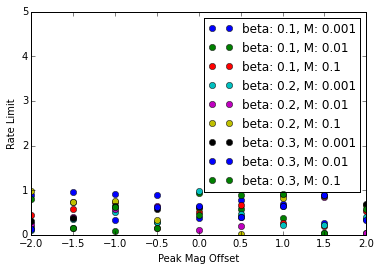

In [7]:
plt.figure()
beta = ['0.1','0.2','0.3']
Msol = ['0.001','0.01','0.1']
legendlist = []
for b in beta:
    for M in Msol:
        rateLims = np.random.rand(9)
        offsets = np.linspace(-2,2,9)
        plt.plot(offsets,rateLims,'o')
        legendlist.append('beta: ' + b + ', M: ' + M)
plt.legend(legendlist)
plt.axis([-2,2,0,5])
plt.xlabel('Peak Mag Offset')
plt.ylabel('Rate Limit')
